<a href="https://colab.research.google.com/github/emanfj/Healthcare-Disparities-Analysis/blob/main/census_2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=ca899d2afcb1b1bc7b48188578bd43b4af71972dba84bcc840dcdb20e6315ef8
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [90]:
# necessary imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan, isnull, struct
from pyspark.sql.functions import lit,mean,when, greatest, sum, countDistinct
from pyspark.sql.functions import row_number, desc
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [4]:
# starting spark session
spark = SparkSession.builder.appName("Census").getOrCreate()

In [5]:
# loading data
demographics = spark.read.csv('/content/drive/MyDrive/2017_census.csv',header=True, inferSchema=True)

In [6]:
# getting the shape of the dataframe
demographics_rows=demographics.count()
demographics_columns=len(demographics.columns)
print('Rows for demographics: ',demographics_rows)
print('Columns for demographics: ',demographics_columns)

Rows for demographics:  74001
Columns for demographics:  37


In [7]:
demographics.printSchema()

root
 |-- TractId: long (nullable = true)
 |-- State: string (nullable = true)
 |-- County: string (nullable = true)
 |-- TotalPop: integer (nullable = true)
 |-- Men: integer (nullable = true)
 |-- Women: integer (nullable = true)
 |-- Hispanic: double (nullable = true)
 |-- White: double (nullable = true)
 |-- Black: double (nullable = true)
 |-- Native: double (nullable = true)
 |-- Asian: double (nullable = true)
 |-- Pacific: double (nullable = true)
 |-- VotingAgeCitizen: integer (nullable = true)
 |-- Income: double (nullable = true)
 |-- IncomeErr: double (nullable = true)
 |-- IncomePerCap: double (nullable = true)
 |-- IncomePerCapErr: double (nullable = true)
 |-- Poverty: double (nullable = true)
 |-- ChildPoverty: double (nullable = true)
 |-- Professional: double (nullable = true)
 |-- Service: double (nullable = true)
 |-- Office: double (nullable = true)
 |-- Construction: double (nullable = true)
 |-- Production: double (nullable = true)
 |-- Drive: double (nullable = 

In [8]:
#formatting of columns for demographics data
demographics = demographics \
    .withColumnRenamed("TotalPop", "TotalPopulation") \
    .withColumnRenamed("Hispanic", "HispanicPercentage") \
    .withColumnRenamed("White", "WhitePercentage") \
    .withColumnRenamed("Black", "BlackPercentage") \
    .withColumnRenamed("Native", "NativePercentage") \
    .withColumnRenamed("Asian", "AsianPercentage") \
    .withColumnRenamed("Pacific", "PacificPercentage") \
    .withColumnRenamed("Income", "MedianHouseholdIncome") \
    .withColumnRenamed("IncomeErr", "MedianHouseholdIncomeError") \
    .withColumnRenamed("IncomePerCap", "IncomePerCapita") \
    .withColumnRenamed("IncomePerCapErr", "IncomePerCapitaError") \
    .withColumnRenamed("OtherTransp", "OtherTransportation")  \
    .withColumnRenamed("MeanCommute", "MeanCommuteTime")

In [9]:
# filtering out rows that have no recorded population
demographics = demographics.filter(demographics.TotalPopulation > 0)
demographics.count()

73305

In [10]:
# percentage of missing values in each column
missing_percentage = demographics.select([(count(when(isnan(c) | col(c).isNull(), c))/count(lit(1))).alias(c) for c in demographics.columns])
missing_percentage.show()

+-------+-----+------+---------------+---+-----+------------------+---------------+---------------+----------------+---------------+-----------------+----------------+---------------------+--------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|TractId|State|County|TotalPopulation|Men|Women|HispanicPercentage|WhitePercentage|BlackPercentage|NativePercentage|AsianPercentage|PacificPercentage|VotingAgeCitizen|MedianHouseholdIncome|MedianHouseholdIncomeError|     IncomePerCapita|IncomePerCapitaError|             Poverty|        ChildPoverty|        Professional|            

In [11]:
# get mean values for each numeric column
numeric_columns = [col_name for col_name, col_type in demographics.dtypes if col_type != 'string']
means = demographics.select(*(mean(col(c)).alias(c) for c in numeric_columns))

# extract mean values from DataFrame
mean_values = means.first().asDict()

# fill null values with mean for numeric columns
for col_name in numeric_columns:
    demographics = demographics.na.fill(mean_values[col_name], [col_name])

# show df after imputation
demographics.show()

+----------+-------+--------------+---------------+----+-----+------------------+---------------+---------------+----------------+---------------+-----------------+----------------+---------------------+--------------------------+---------------+--------------------+-------+------------+------------+-------+------+------------+----------+-----+-------+-------+----+-------------------+----------+---------------+--------+-----------+----------+------------+----------+------------+
|   TractId|  State|        County|TotalPopulation| Men|Women|HispanicPercentage|WhitePercentage|BlackPercentage|NativePercentage|AsianPercentage|PacificPercentage|VotingAgeCitizen|MedianHouseholdIncome|MedianHouseholdIncomeError|IncomePerCapita|IncomePerCapitaError|Poverty|ChildPoverty|Professional|Service|Office|Construction|Production|Drive|Carpool|Transit|Walk|OtherTransportation|WorkAtHome|MeanCommuteTime|Employed|PrivateWork|PublicWork|SelfEmployed|FamilyWork|Unemployment|
+----------+-------+------------

In [12]:
# find duplicate rows across all cols
demographics.exceptAll(demographics.dropDuplicates()).show()

+-------+-----+------+---------------+---+-----+------------------+---------------+---------------+----------------+---------------+-----------------+----------------+---------------------+--------------------------+---------------+--------------------+-------+------------+------------+-------+------+------------+----------+-----+-------+-------+----+-------------------+----------+---------------+--------+-----------+----------+------------+----------+------------+
|TractId|State|County|TotalPopulation|Men|Women|HispanicPercentage|WhitePercentage|BlackPercentage|NativePercentage|AsianPercentage|PacificPercentage|VotingAgeCitizen|MedianHouseholdIncome|MedianHouseholdIncomeError|IncomePerCapita|IncomePerCapitaError|Poverty|ChildPoverty|Professional|Service|Office|Construction|Production|Drive|Carpool|Transit|Walk|OtherTransportation|WorkAtHome|MeanCommuteTime|Employed|PrivateWork|PublicWork|SelfEmployed|FamilyWork|Unemployment|
+-------+-----+------+---------------+---+-----+------------

In [18]:
# display unique values in string dtype cols
unique_states=demographics.select("State").distinct().count()
unique_county=demographics.select("County").distinct().count()
print(f"Number of States: ", unique_states)
print(f"Number of County: ", unique_county)
demographics.select("State").distinct().show(52)

Number of States:  52
Number of County:  1955
+--------------------+
|               State|
+--------------------+
|              Hawaii|
|           Minnesota|
|            Arkansas|
|         Connecticut|
|            Nebraska|
|              Nevada|
|            Illinois|
|District of Columbia|
|            Delaware|
|              Alaska|
|          New Mexico|
|            Missouri|
|             Georgia|
|             Montana|
|            Michigan|
|              Kansas|
|          New Jersey|
|            Maryland|
|             Alabama|
|             Arizona|
|                Iowa|
|       Massachusetts|
|            Kentucky|
|           Louisiana|
|         Mississippi|
|       New Hampshire|
|             Florida|
|             Indiana|
|               Idaho|
|          California|
|            New York|
|            Colorado|
|               Maine|
|                Utah|
|                Ohio|
|              Oregon|
|               Texas|
|        North Dakota|
|        Pe

+----------+-------+--------------+-------------------+
|   TractId|  State|        County| AgeDependencyRatio|
+----------+-------+--------------+-------------------+
|1001020100|Alabama|Autauga County|0.31130063965884863|
|1001020200|Alabama|Autauga County|0.31476997578692495|
|1001020300|Alabama|Autauga County| 0.3649193548387097|
|1001020400|Alabama|Autauga County| 0.3101013202333436|
|1001020500|Alabama|Autauga County|0.37847558445151475|
|1001020600|Alabama|Autauga County|0.34722739114253814|
|1001020700|Alabama|Autauga County| 0.3475177304964539|
|1001020801|Alabama|Autauga County|0.34674063800277394|
|1001020802|Alabama|Autauga County|0.37403006789524734|
|1001020900|Alabama|Autauga County|0.30934182590233544|
|1001021000|Alabama|Autauga County|0.31144465290806755|
|1001021100|Alabama|Autauga County| 0.2546756864305611|
|1003010100|Alabama|Baldwin County|0.22406384284837325|
|1003010200|Alabama|Baldwin County| 0.4144965277777778|
|1003010300|Alabama|Baldwin County| 0.3921598770

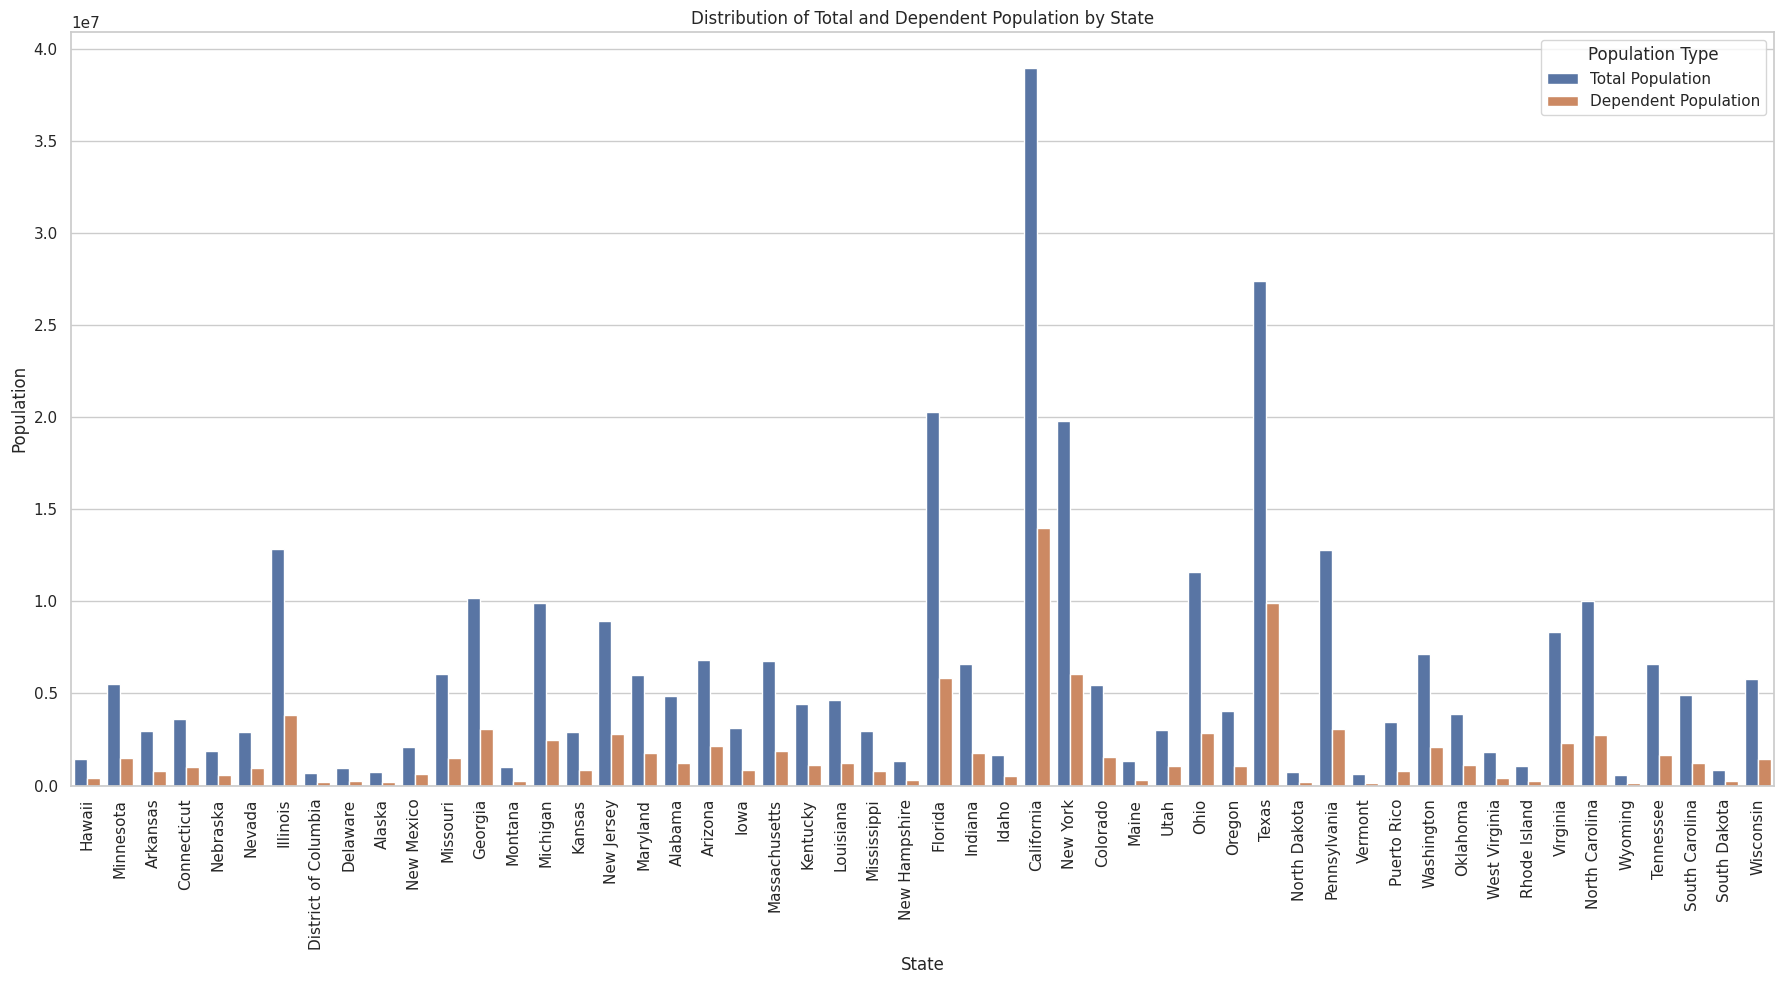

In [24]:
"""deriving a new column for ratio of dependent population (excluding elderly for lack of information)
formula -> population under 18 / population above 18 """

demographics = demographics.withColumn('AgeDependencyRatio', (col('TotalPopulation')-col('VotingAgeCitizen')) / col('VotingAgeCitizen'))
demographics.select("TractId","State","County","AgeDependencyRatio").show()

# group data by State
grouped_data = demographics.groupBy("State")

# calc total population and dependent population
total_population = grouped_data.agg(sum("TotalPopulation").alias("Total Population"))
dependent_population = grouped_data.agg((sum("TotalPopulation") - sum("VotingAgeCitizen")).alias("Dependent Population"))

# combining data into a single DataFrame for plotting
data = total_population.join(dependent_population, on="State")

# converting to pd df for visualization
data_pd = data.toPandas()

# plotting grouped bar chart
plt.figure(figsize=(18,10))
sns.set(style="whitegrid")

# mel the dataframe for easier plotting
data_melted = data_pd.melt(id_vars="State", value_vars=["Total Population", "Dependent Population"],
                           var_name="Population Type", value_name="Population")

# creating a bar plot
bar_plot = sns.barplot(x="State", y="Population", hue="Population Type", data=data_melted)

# set plot labels and title
bar_plot.set_xlabel("State")
bar_plot.set_ylabel("Population")
bar_plot.set_title("Distribution of Total and Dependent Population by State")
plt.legend(title='Population Type')
plt.xticks(rotation=90)
plt.tight_layout()

# show plot
plt.show()

+----------+-------+--------------+----------------------+
|   TractId|  State|        County|HouseholdIncomeBracket|
+----------+-------+--------------+----------------------+
|1001020100|Alabama|Autauga County|                Middle|
|1001020200|Alabama|Autauga County|                Middle|
|1001020300|Alabama|Autauga County|                Middle|
|1001020400|Alabama|Autauga County|                Middle|
|1001020500|Alabama|Autauga County|                Middle|
|1001020600|Alabama|Autauga County|                Middle|
|1001020700|Alabama|Autauga County|                Middle|
|1001020801|Alabama|Autauga County|                  High|
|1001020802|Alabama|Autauga County|                Middle|
|1001020900|Alabama|Autauga County|                Middle|
|1001021000|Alabama|Autauga County|                Middle|
|1001021100|Alabama|Autauga County|                Middle|
|1003010100|Alabama|Baldwin County|                Middle|
|1003010200|Alabama|Baldwin County|                Middl

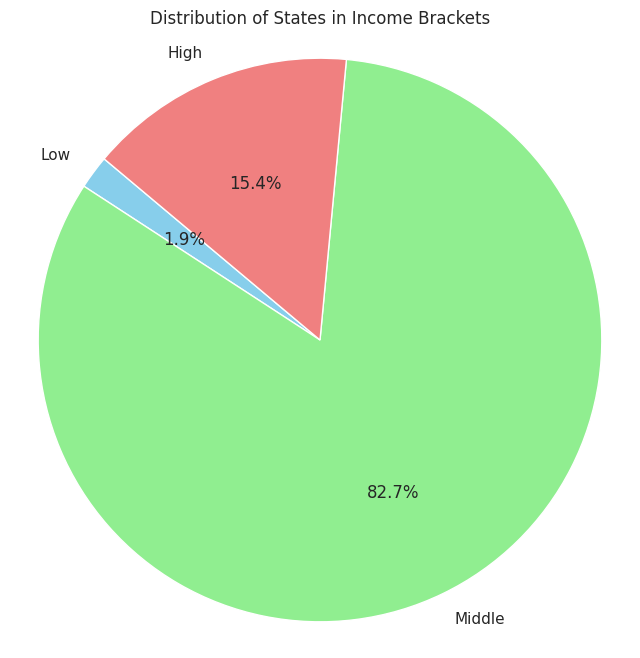

In [43]:
# deriving a column for income bracket for each census tract
demographics = demographics.withColumn('HouseholdIncomeBracket',
                                       when(col('MedianHouseholdIncome') < 30000, 'Low')
                                       .when((col('MedianHouseholdIncome') >= 30000) & (col('MedianHouseholdIncome') < 70000), 'Middle')
                                       .otherwise('High'))

demographics.select("TractId","State","County","HouseholdIncomeBracket").show()

# grouping by state and income bracket
# counting the no of occurences of each income bracket within each state
state_income_data = demographics.groupBy('State', 'HouseholdIncomeBracket').count().collect()

# collecting data for plotting into a dictionary
state_income_dict = {}
for row in state_income_data:
    state = row['State']
    income_bracket = row['HouseholdIncomeBracket']
    count = row['count']
    if state not in state_income_dict:
        state_income_dict[state] = {'Low': 0, 'Middle': 0, 'High': 0}
    state_income_dict[state][income_bracket] += count

# counting the predominant income bracket for each state
state_counts = {'Low': 0, 'Middle': 0, 'High': 0}
for state, data in state_income_dict.items():
    predominant_bracket = max(data, key=data.get)
    state_counts[predominant_bracket] += 1

# plotting the pie chart for state counts
labels = list(state_counts.keys())
counts = list(state_counts.values())

plt.figure(figsize=(8,8))
explode = (0.1, 0, 0)
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'lightcoral'])
plt.title("Distribution of States in Income Brackets")
plt.axis('equal')
plt.show()

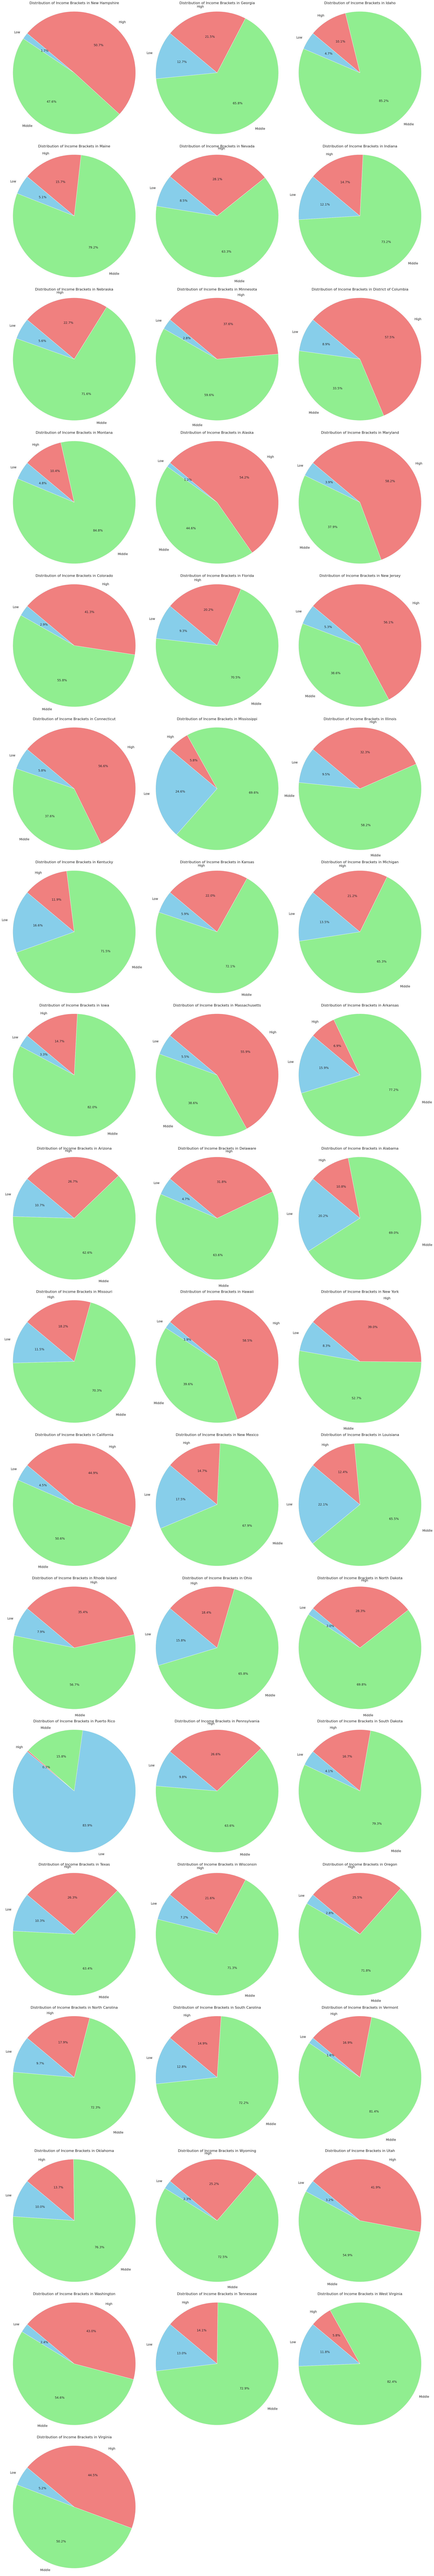

In [45]:
# visualizing the distribution of income brackets in each state
num_states = len(state_income_dict)
num_cols = 3
num_rows = num_states // num_cols + (1 if num_states % num_cols != 0 else 0)

# plotting the pie charts for each state
fig, axes = plt.subplots(num_rows, num_cols, figsize=(27, 9*num_rows))

for i, (state, data) in enumerate(state_income_dict.items()):
    income_brackets = list(data.keys())
    counts = list(data.values())

    row_idx = i // num_cols
    col_idx = i % num_cols

    ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx]
    ax.pie(counts, labels=income_brackets, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'lightcoral'],textprops={'fontsize': 14})
    ax.set_title(f"Distribution of Income Brackets in {state}",fontsize=16)
    ax.axis('equal')

# hiding any empty subplots
for i in range(num_states, num_rows*num_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    axes[row_idx, col_idx].axis('off')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.tight_layout()
plt.show()

+----------+-------+--------------+----------------------+
|   TractId|  State|        County|SimpsonsDiversityIndex|
+----------+-------+--------------+----------------------+
|1001020100|Alabama|Autauga County|    0.2518069999999999|
|1001020200|Alabama|Autauga County|    0.5296979999999999|
|1001020300|Alabama|Autauga County|    0.5462779999999999|
|1001020400|Alabama|Autauga County|    0.3409050000000001|
|1001020500|Alabama|Autauga County|    0.3714369999999999|
|1001020600|Alabama|Autauga County|    0.4362499999999999|
|1001020700|Alabama|Autauga County|   0.37119499999999983|
|1001020801|Alabama|Autauga County|              0.248201|
|1001020802|Alabama|Autauga County|    0.3071710000000001|
|1001020900|Alabama|Autauga County|    0.2473740000000001|
|1001021000|Alabama|Autauga County|   0.42259800000000014|
|1001021100|Alabama|Autauga County|              0.504682|
|1003010100|Alabama|Baldwin County|              0.395385|
|1003010200|Alabama|Baldwin County|    0.237228000000000

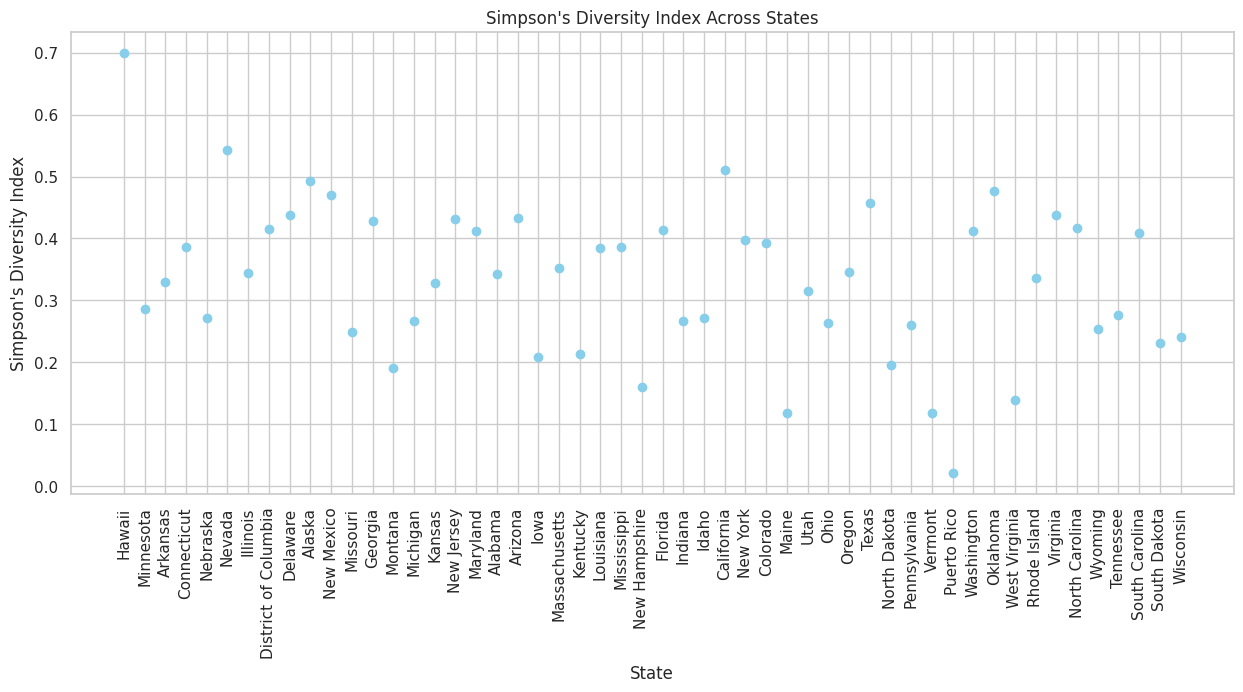

In [49]:
"""deriving a column for ethnic diversity based on Simpson's Diversity Index
formula -> (1 - (sum of squared error of each ethnic group))
the values lie between 0 and 1 with values closer to 0 indicating low diversity
and values closer to 1 indicating high diversity and ethnic distribution"""

demographics = demographics.withColumn('SimpsonsDiversityIndex', 1 -
                                       (((col('HispanicPercentage')/100)**2) +
                                        ((col('WhitePercentage')/100)** 2) +
                                        ((col('BlackPercentage')/100)** 2) +
                                        ((col('NativePercentage')/100)** 2) +
                                        ((col('AsianPercentage')/100)** 2) +
                                        ((col('PacificPercentage')/100)** 2)))

demographics.select('TractId', 'State', 'County', 'SimpsonsDiversityIndex').show()

# grouping by state and aggregating Simpson's Diversity Index based on the avg
# for each state
state_diversity = demographics.groupBy('State').agg({'SimpsonsDiversityIndex': 'mean'}).collect()

# extracting data for plotting
states = [row['State'] for row in state_diversity]
diversity_indices = [row['avg(SimpsonsDiversityIndex)'] for row in state_diversity]

# plotting a scatter plot
plt.figure(figsize=(15, 6))
plt.scatter(states, diversity_indices, color='skyblue')
plt.xlabel('State')
plt.ylabel("Simpson's Diversity Index")
plt.title("Simpson's Diversity Index Across States")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


+----------+-------+--------------+------------------+
|   TractId|  State|        County|       GenderRatio|
+----------+-------+--------------+------------------+
|1001020100|Alabama|Autauga County|0.9503171247357294|
|1001020200|Alabama|Autauga County|1.1611940298507464|
|1001020300|Alabama|Autauga County|0.8277537796976242|
|1001020400|Alabama|Autauga County| 0.883053839364519|
|1001020500|Alabama|Autauga County|1.0291183058440236|
|1001020600|Alabama|Autauga County|0.9514824797843666|
|1001020700|Alabama|Autauga County|0.7440081591024987|
|1001020801|Alabama|Autauga County|1.0543018335684062|
|1001020802|Alabama|Autauga County|0.9389221556886228|
|1001020900|Alabama|Autauga County| 1.017997382198953|
|1001021000|Alabama|Autauga County|1.0619469026548674|
|1001021100|Alabama|Autauga County|0.8925570228091236|
|1003010100|Alabama|Baldwin County|1.1936193619361937|
|1003010200|Alabama|Baldwin County|0.8762233736327001|
|1003010300|Alabama|Baldwin County|0.9358700299273194|
|100301040

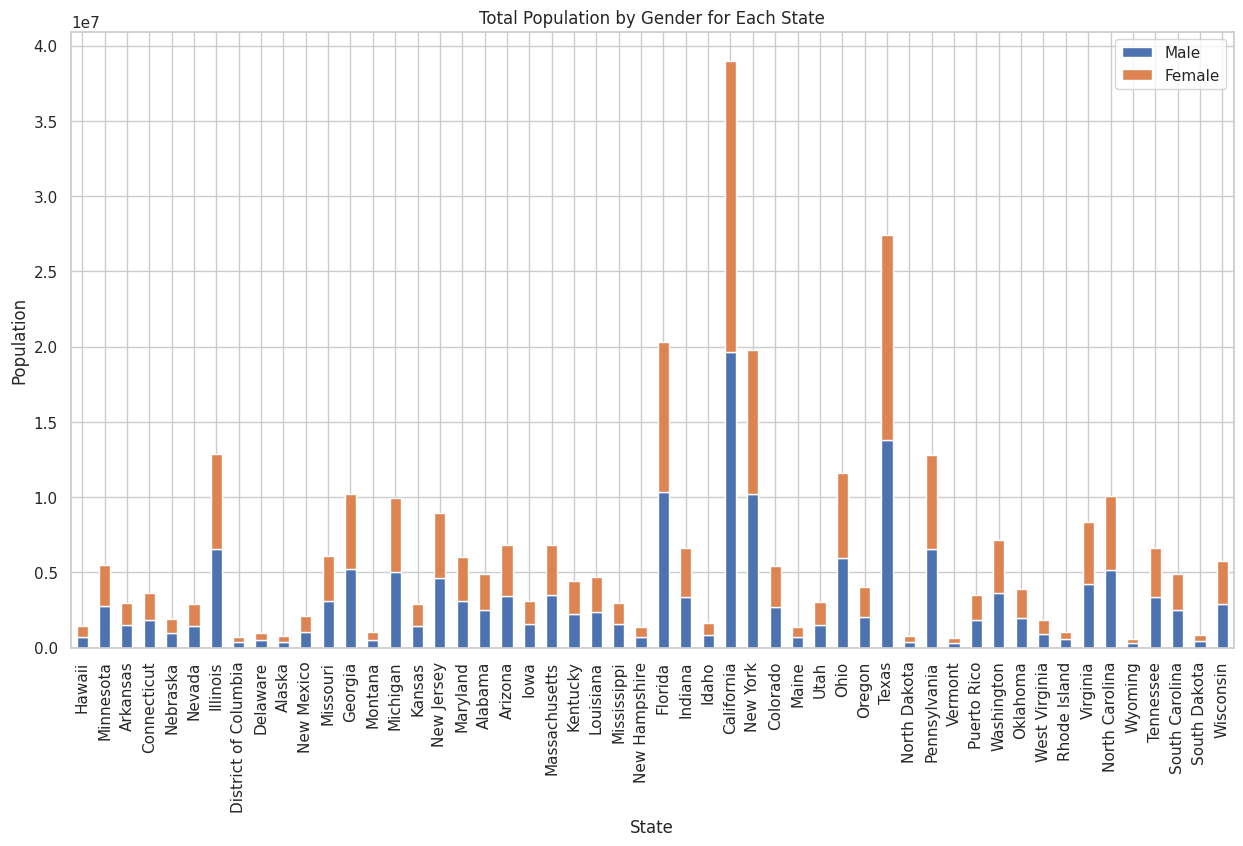

In [63]:
"""deriving column for gender ratio of men to women
values less than 1 indicate more men than women
values more than 1 indicate more women than men
value exactly at 1 indicates equal population of men and women"""

demographics = demographics.withColumn('GenderRatio', col('Men') / col('Women'))

demographics.select('TractId', 'State', 'County', 'GenderRatio').show()

# aggregate data to get total male and female populations for each state
state_population = demographics.groupBy('State').agg({'Men': 'sum', 'Women': 'sum'}).toPandas()

# plotting stacked bar chart
state_population.plot(kind='bar', stacked=True, x='State', figsize=(15, 8))
plt.title('Total Population by Gender for Each State')
plt.xlabel('State')
plt.ylabel('Population')
plt.legend(['Male', 'Female'])
plt.show()

In [94]:
# deriving column for most common mode of commute
commute_methods = ['Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransportation', 'WorkAtHome']
demographics = demographics.withColumn('DominantCommuteMethod',
                                       when(col('Drive') == greatest(*[col(method) for method in commute_methods]), 'Drive')
                                       .when(col('Carpool') == greatest(*[col(method) for method in commute_methods]), 'Carpool')
                                       .when(col('Transit') == greatest(*[col(method) for method in commute_methods]), 'Transit')
                                       .when(col('Walk') == greatest(*[col(method) for method in commute_methods]), 'Walk')
                                       .when(col('OtherTransportation') == greatest(*[col(method) for method in commute_methods]), 'Other')
                                       .when(col('WorkAtHome') == greatest(*[col(method) for method in commute_methods]), 'WFH')
                                       .otherwise('Unknown'))
